# 의사결정나무(Desicion Tree)
이상치에 안 민감?

## Hitters 데이터셋

### target 변수: Salary - 선수의 시즌 연봉(단위: 달러)

### 설명변수

1. 타격 및 경기 관련 설명변수
* AtBat: 시즌 동안 타석에 들어선 횟수
* Hits: 시즌 동안 안타를 친 횟수
* HmRun: 시즌 동안의 홈런 수
* Runs: 시즌 득점 수
* RBI(Runs Batted In): 타점, 즉 안타로 인해 팀 동료들이 득점할 수 있도록 도운 횟수
* Walks: 볼넷 횟수
2. 경력 관련 설명변수
* Years: 메이저 리그에서의 경력 연수
* CAtBat, CHits, CRuns, CRBI, CWalks: 선수의 커리어 전반에 걸친 누적 타석 수, 안타 수, 득점, 타점, 볼넷 횟수 등
3. 팀 및 리그 관련 설명변수
* League: 선수 소속 리그(예: National League 또는 American League)
* Division: 리그 내 해당 팀의 소속 디비전(예: 동부 또는 서부)
4. 수비 관련 설명변수
* PutOuts, Assists, Errors

### 의사결정나무 모형의 내재된 변수 선택 기능
1. 분할 기준:
* 의사결정나무는 각 노드 분할 시, 모든 후보 변수를 평가하여 불순도(회귀의 경우 squared_error, 분류의 경우 지니 불순도나 엔트로피 등)를 가장 크게 감소시키는 변수와 분할 기준을 선택한다.
* 이 과정에서 영향력이 적은 변수는 분할에 사용되지 않고, 영향력이 큰 변수만 선택되므로 자동 변수 선택 효과가 발생한다.

2. 변수 중요도:
학습이 완료된 후, 트리 기반 모형은 각 변수의 중요도(feature importance)를 평가할 수 있는 값을 제공한다. 이 값들은 모형이 분할 과정에서 각 변수에 얼마나 의존했는지를 나타내며, 별도의 변수를 사전에 선택하지 않아도 중요한 특성을 반영한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

In [4]:
df = pd.read_csv('Hitters.csv')

In [13]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [14]:
df.info() # salary -> target variable -> 회귀 테스크이다..!

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64(1), 

In [8]:
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,263.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,535.925882
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,451.118681
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,190.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,425.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000


In [9]:
df.shape

(322, 20)

In [10]:
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [11]:
# 결측치가 있는 샘플을 제거한다
df = df.dropna()

In [12]:
df.shape

(263, 20)

In [15]:
### 범주형 변수('League', 'Division', 'NewLeague') 인코딩 ###
categorical_columns = ['League', 'Division', 'NewLeague']

In [16]:
for col in categorical_columns:
    if col in df.columns:
        print(f"\n{col}의 고유값:", df[col].unique())


League의 고유값: ['N' 'A']

Division의 고유값: ['W' 'E']

NewLeague의 고유값: ['N' 'A']


In [17]:
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [18]:
df_encoded.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,True,True,True
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,False,True,False
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,True,False,True
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,True,False,True
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,False,True,False


In [20]:
df_encoded.shape

(263, 20)

In [21]:
X = df_encoded.drop('Salary', axis=1)
y = df_encoded['Salary']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
X_train.shape, X_test.shape

((184, 19), (79, 19))

In [36]:
'''
param_grid = {
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
'''

# max_depth: 트리의 최대 깊이
# min_samples_split: 내부 노드를 분할하는 데 필요한 최소 샘플 수
# min_samples_leaf: 리프 노드에 있어야 하는 최소 샘플 수

param_grid = {
    'max_depth': list(range(3, 11)),            # 3부터 10까지의 정수값
    'min_samples_split': list(range(2, 11)),    # 2부터 10까지의 정수값
    'min_samples_leaf': list(range(1, 5))       # 1부터 4까지의 정수값
}

In [43]:
# GridSearchCV 설정 (5-fold cross-validation 사용): 최적의 하이퍼파라미터 조합 선택
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,   
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

# param_grid=param_grid: 튜닝할 하이퍼파라미터와 그 후보 값들을 딕셔너리 형태로 전달한다
#                        param_grid에는 max_depth, min_samples_split, min_samples_leaf 등의
#                        하이퍼파라미터에 대해 탐색할 값들의 리스트가 포함되어 있다

# scoring='neg_mean_squared_error': 평가지표 => Negative Mean Squared Error, neg_MSE
#                                   MSE에 음수를 취한 값을 사용한다
#                                   이 값이 클수록(즉, 음수의 절댓값이 작을수록) 좋은 모형으로 평가된다

# n_jobs=-1: GridSearchCV 수행 시, 가능한 모든 CPU 코어를 사용하여 병렬 처리를 진행한다
#            n_jobs=-1 => 시스템에 사용 가능한 모든 프로세서를 활용          

In [44]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [45]:
print("\n[GridSearchCV 결과]")
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적 CV MSE (음수):", grid_search.best_score_)


[GridSearchCV 결과]
최적의 하이퍼파라미터: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 9}
최적 CV MSE (음수): -85464.23521770255


In [46]:
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

In [47]:
print("\n[최적 모델 평가]")
print("최적 모델 MSE:", mse_best)
print("최적 모델 R2 Score:", r2_best)


[최적 모델 평가]
최적 모델 MSE: 171153.7321633548
최적 모델 R2 Score: 0.29518632332297345


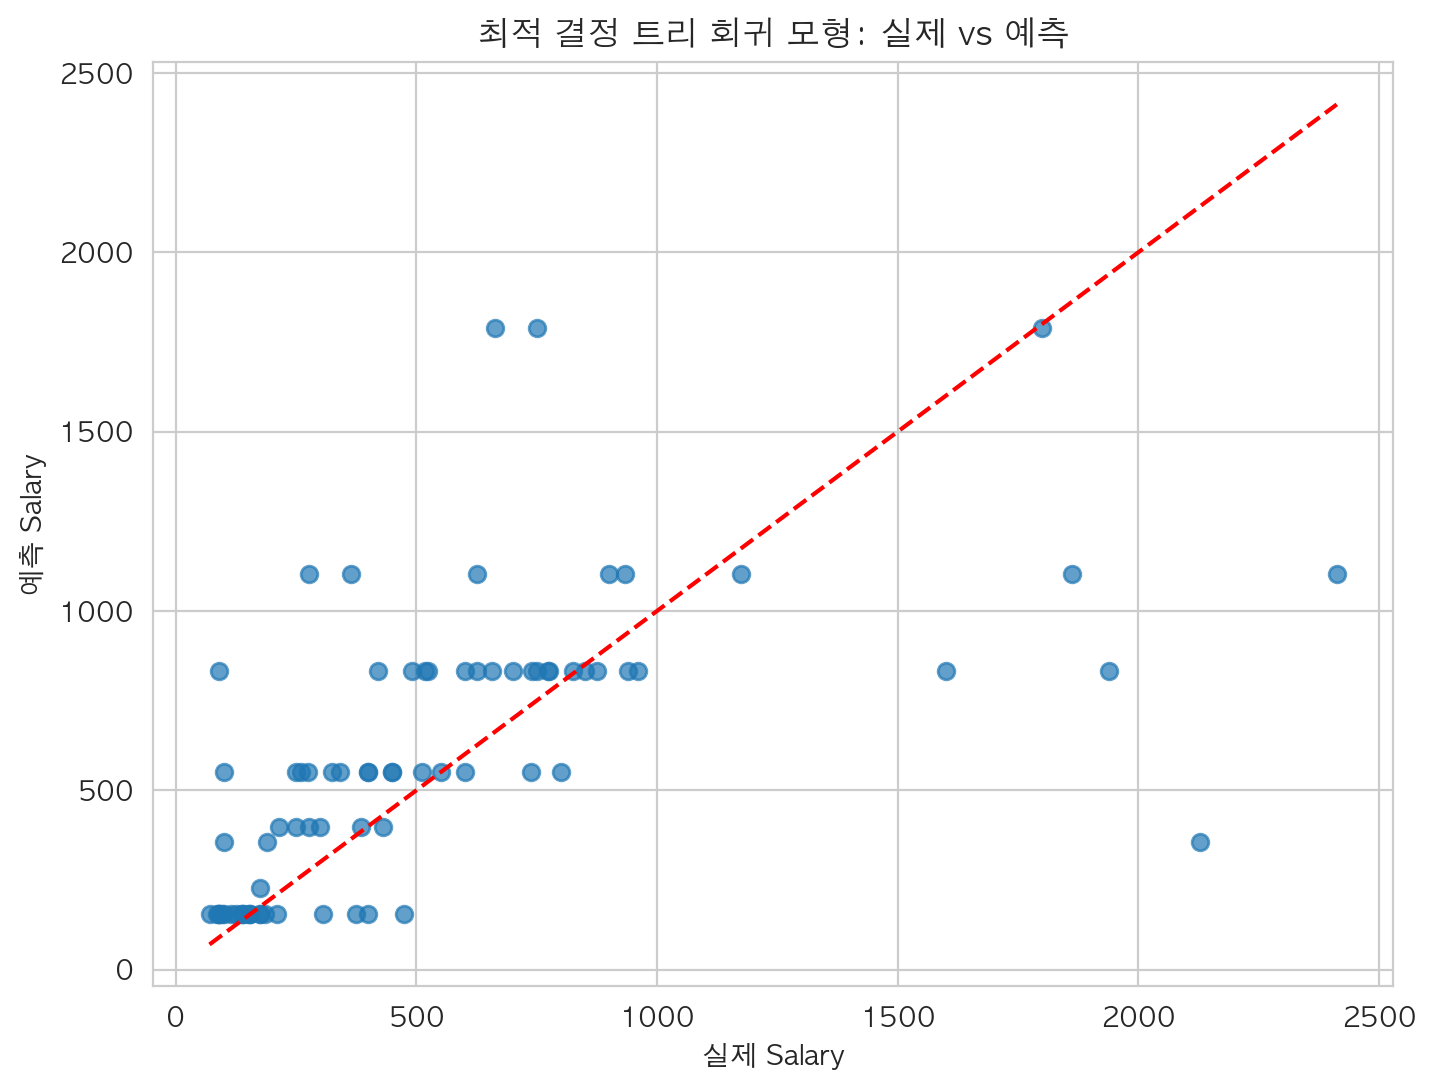

In [31]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rc('font', family='AppleGothic')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('실제 Salary')
plt.ylabel('예측 Salary')
plt.title('최적 결정 트리 회귀 모형: 실제 vs 예측')
plt.show()

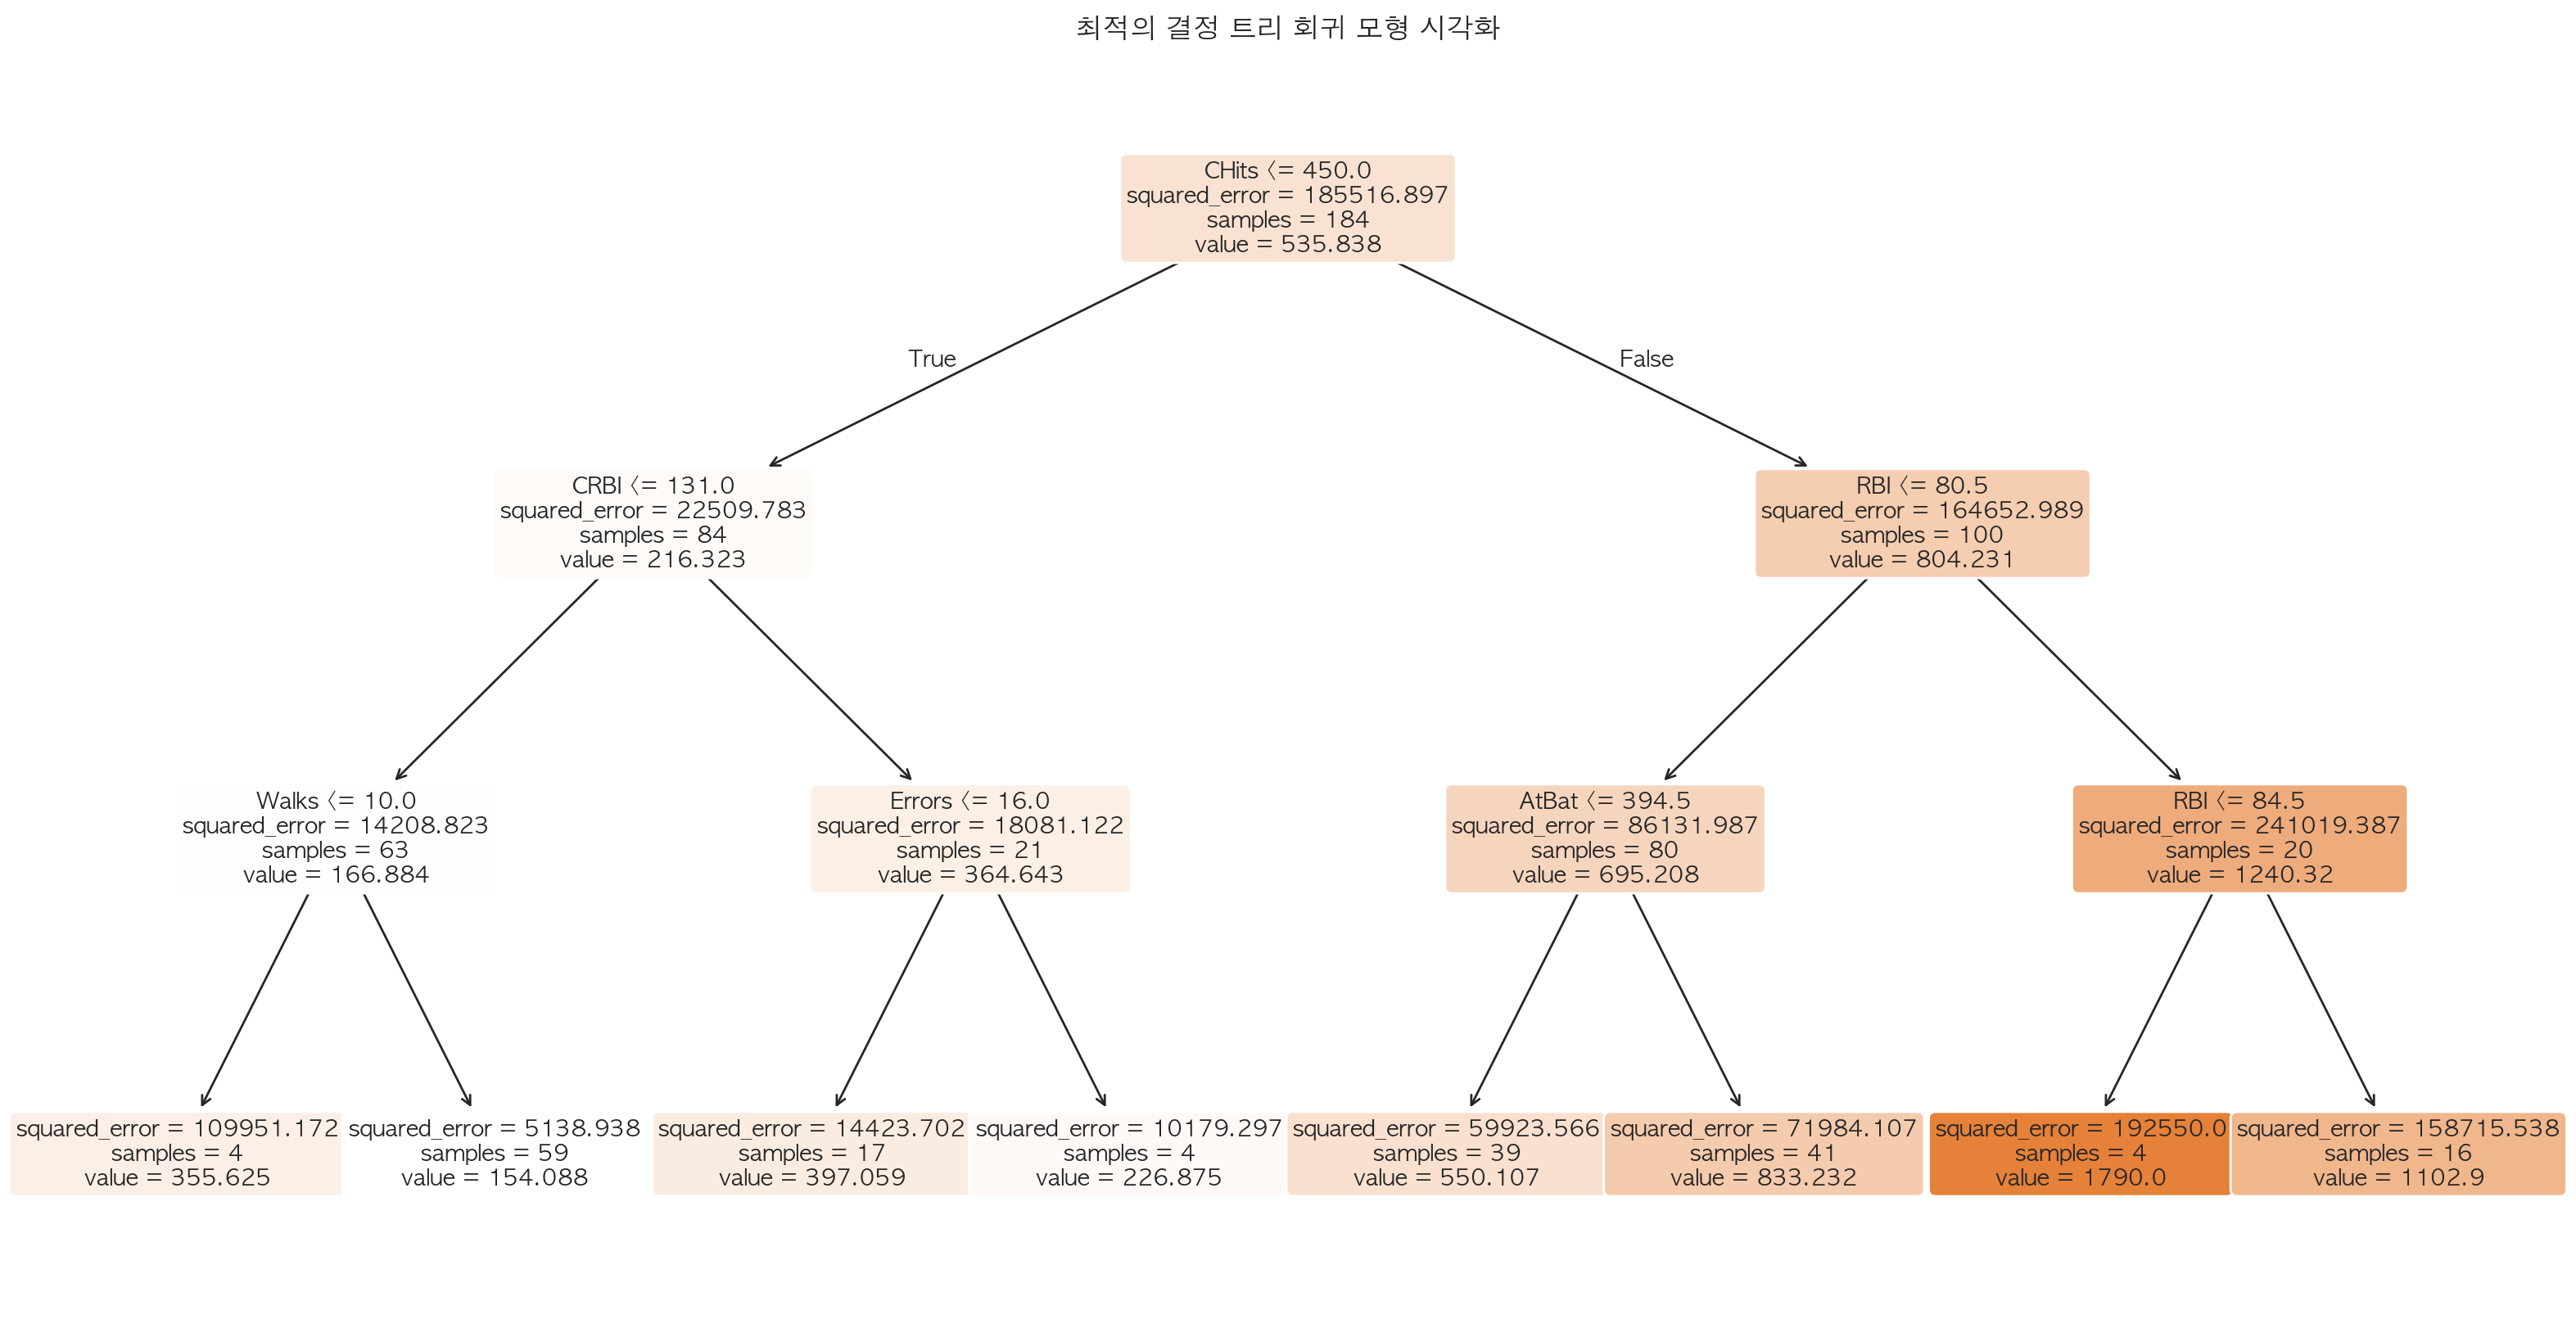

In [32]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt, 
          filled=True, 
          feature_names=list(X.columns), 
          rounded=True, 
          fontsize=10)
plt.title("최적의 결정 트리 회귀 모형 시각화")
plt.show()

# filled=True: 각 노드를 색칠하여 예측 값(또는 분류 결과) 등 정보를 표현
# feature_names: 설명 변수 이름들을 표시하여 어떤 변수가 사용되었는지 확인
# rounded=True: 노드 박스를 둥글게 표현하여 가독성 향상
# fontsize: 글자 크기를 지정하여 전체 트리의 가독성을 높임

In [48]:
# 최적의 모델(best_dt)에서 각 변수의 중요도(feature_importances_) 값을 추출한다
importances = best_dt.feature_importances_

In [49]:
feature_names = list(X.columns)

In [50]:
# 중요도 순서대로 정렬하기 위해 인덱스 배열 생성 (내림차순 정렬)
indices = np.argsort(importances)[::-1]

# np.argsort(importances): 배열 importances에 있는 값들을 정렬했을 때
#                          원래 배열의 각 원소가 몇 번째 인덱스에 위치해야 하는지를 나타내는 인덱스 배열을 반환한다
#                          기본적으로 반환되는 인덱스 배열은 오름차순으로 정렬된 순서를 따른다
# 슬라이싱 [start:stop:step]: step을 -1로 설정하면 배열의 마지막 원소부터 시작하여 첫 번째 원소까지 거꾸로 나열된다
#                             => 내림차순 정렬

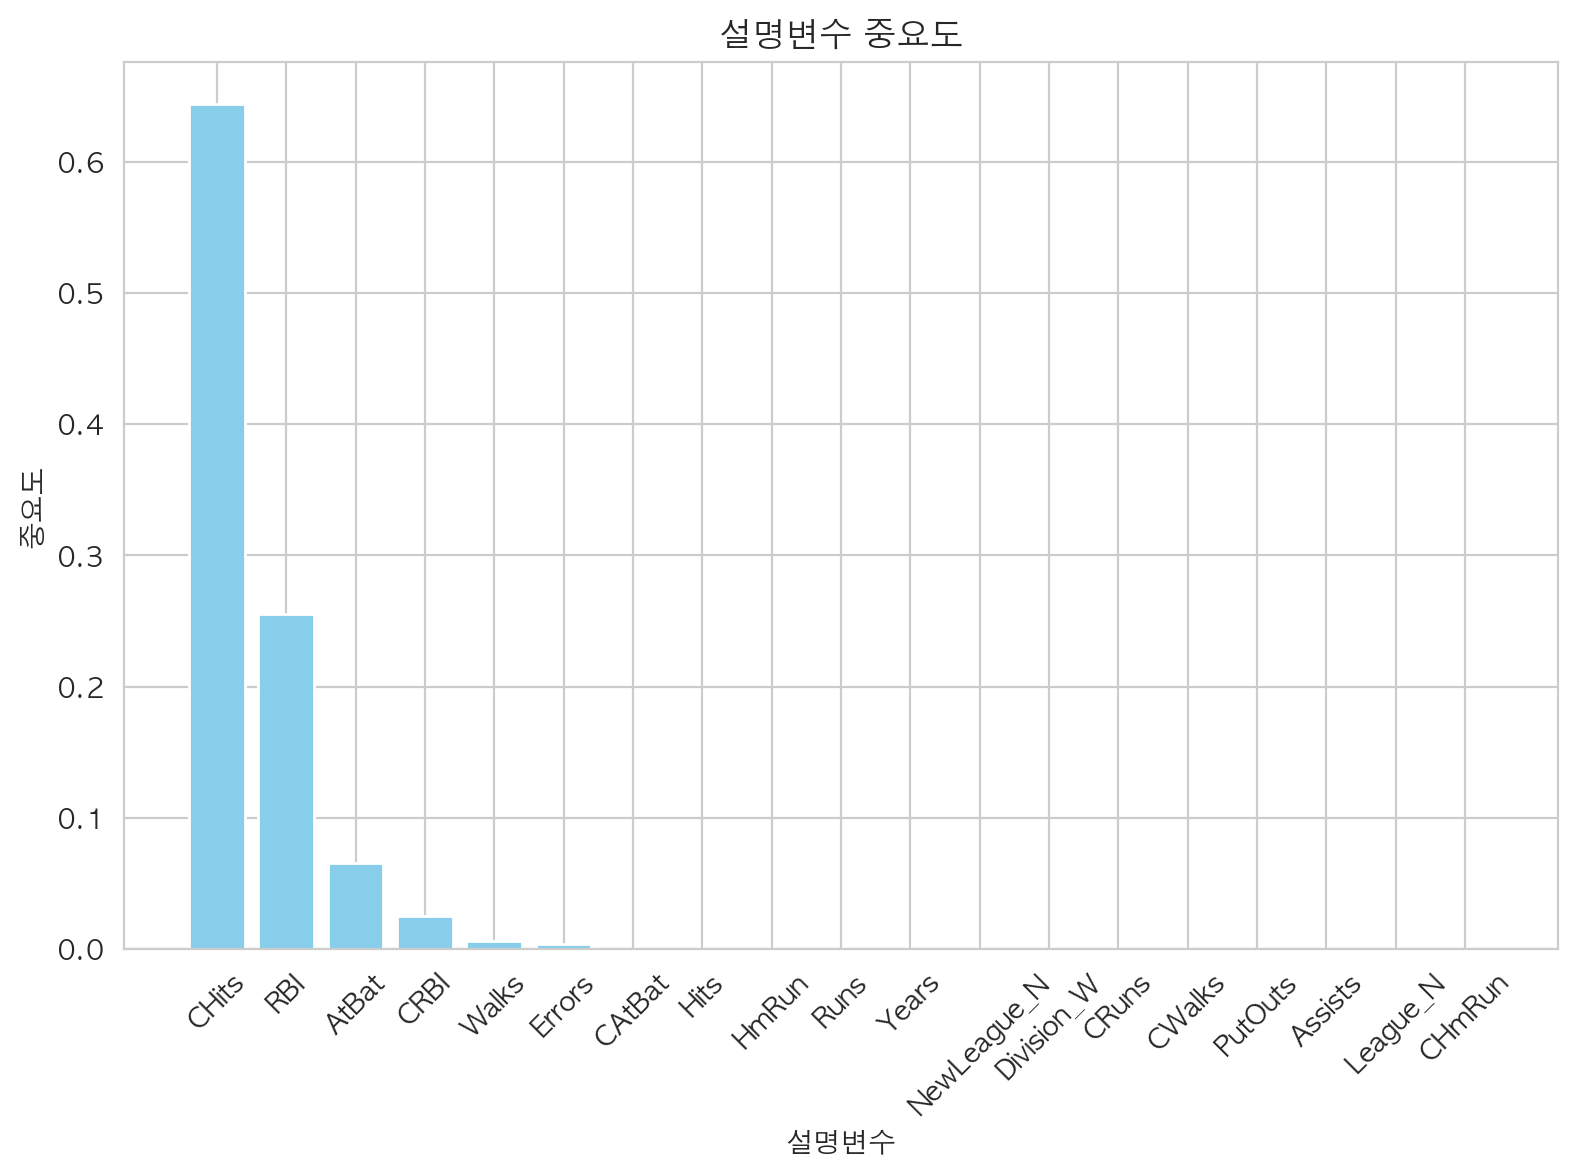

In [51]:
plt.figure(figsize=(8, 6))
plt.title("설명변수 중요도")
plt.bar(range(len(feature_names)), importances[indices], color='skyblue', align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("설명변수")
plt.ylabel("중요도")
plt.tight_layout()
plt.show()

In [52]:
df_reduced = df[['Salary', 'CHits', 'RBI', 'AtBat', 'Walks', 'Errors']]
df_reduced.head()

,Salary,CHits,RBI,AtBat,Walks,Errors
1,475.0,835,38,315,39,10
2,480.0,457,72,479,76,14
3,500.0,1575,78,496,37,3
4,91.5,101,42,321,30,4
5,750.0,1133,51,594,35,25


In [53]:
X = df_reduced[['CHits', 'RBI', 'AtBat', 'Walks', 'Errors']]
y = df_reduced['Salary']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
X_train.shape, X_test.shape

((184, 5), (79, 5))

In [56]:
param_grid = {
    'max_depth': list(range(3, 11)),         
    'min_samples_split': list(range(2, 11)),   
    'min_samples_leaf': list(range(1, 5))       
}

In [57]:
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

In [58]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_mean_squared_error')

In [59]:
print("\n[GridSearchCV 결과]")
print("최적의 하이퍼파라미터:", grid_search.best_params_)
print("최적 교차 검증 점수 (음수 MSE):", grid_search.best_score_)


[GridSearchCV 결과]
최적의 하이퍼파라미터: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
최적 교차 검증 점수 (음수 MSE): -90476.91005515683


In [60]:
# 8. 최적 하이퍼파라미터로 모델 평가
best_dt = grid_search.best_estimator_
y_pred_best = best_dt.predict(X_test)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

In [61]:
print("\n[최적 모델 평가]")
print("최적 모델 MSE:", mse_best)
print("최적 모델 R2 Score:", r2_best)


[최적 모델 평가]
최적 모델 MSE: 168574.69770296215
최적 모델 R2 Score: 0.3058068265239856


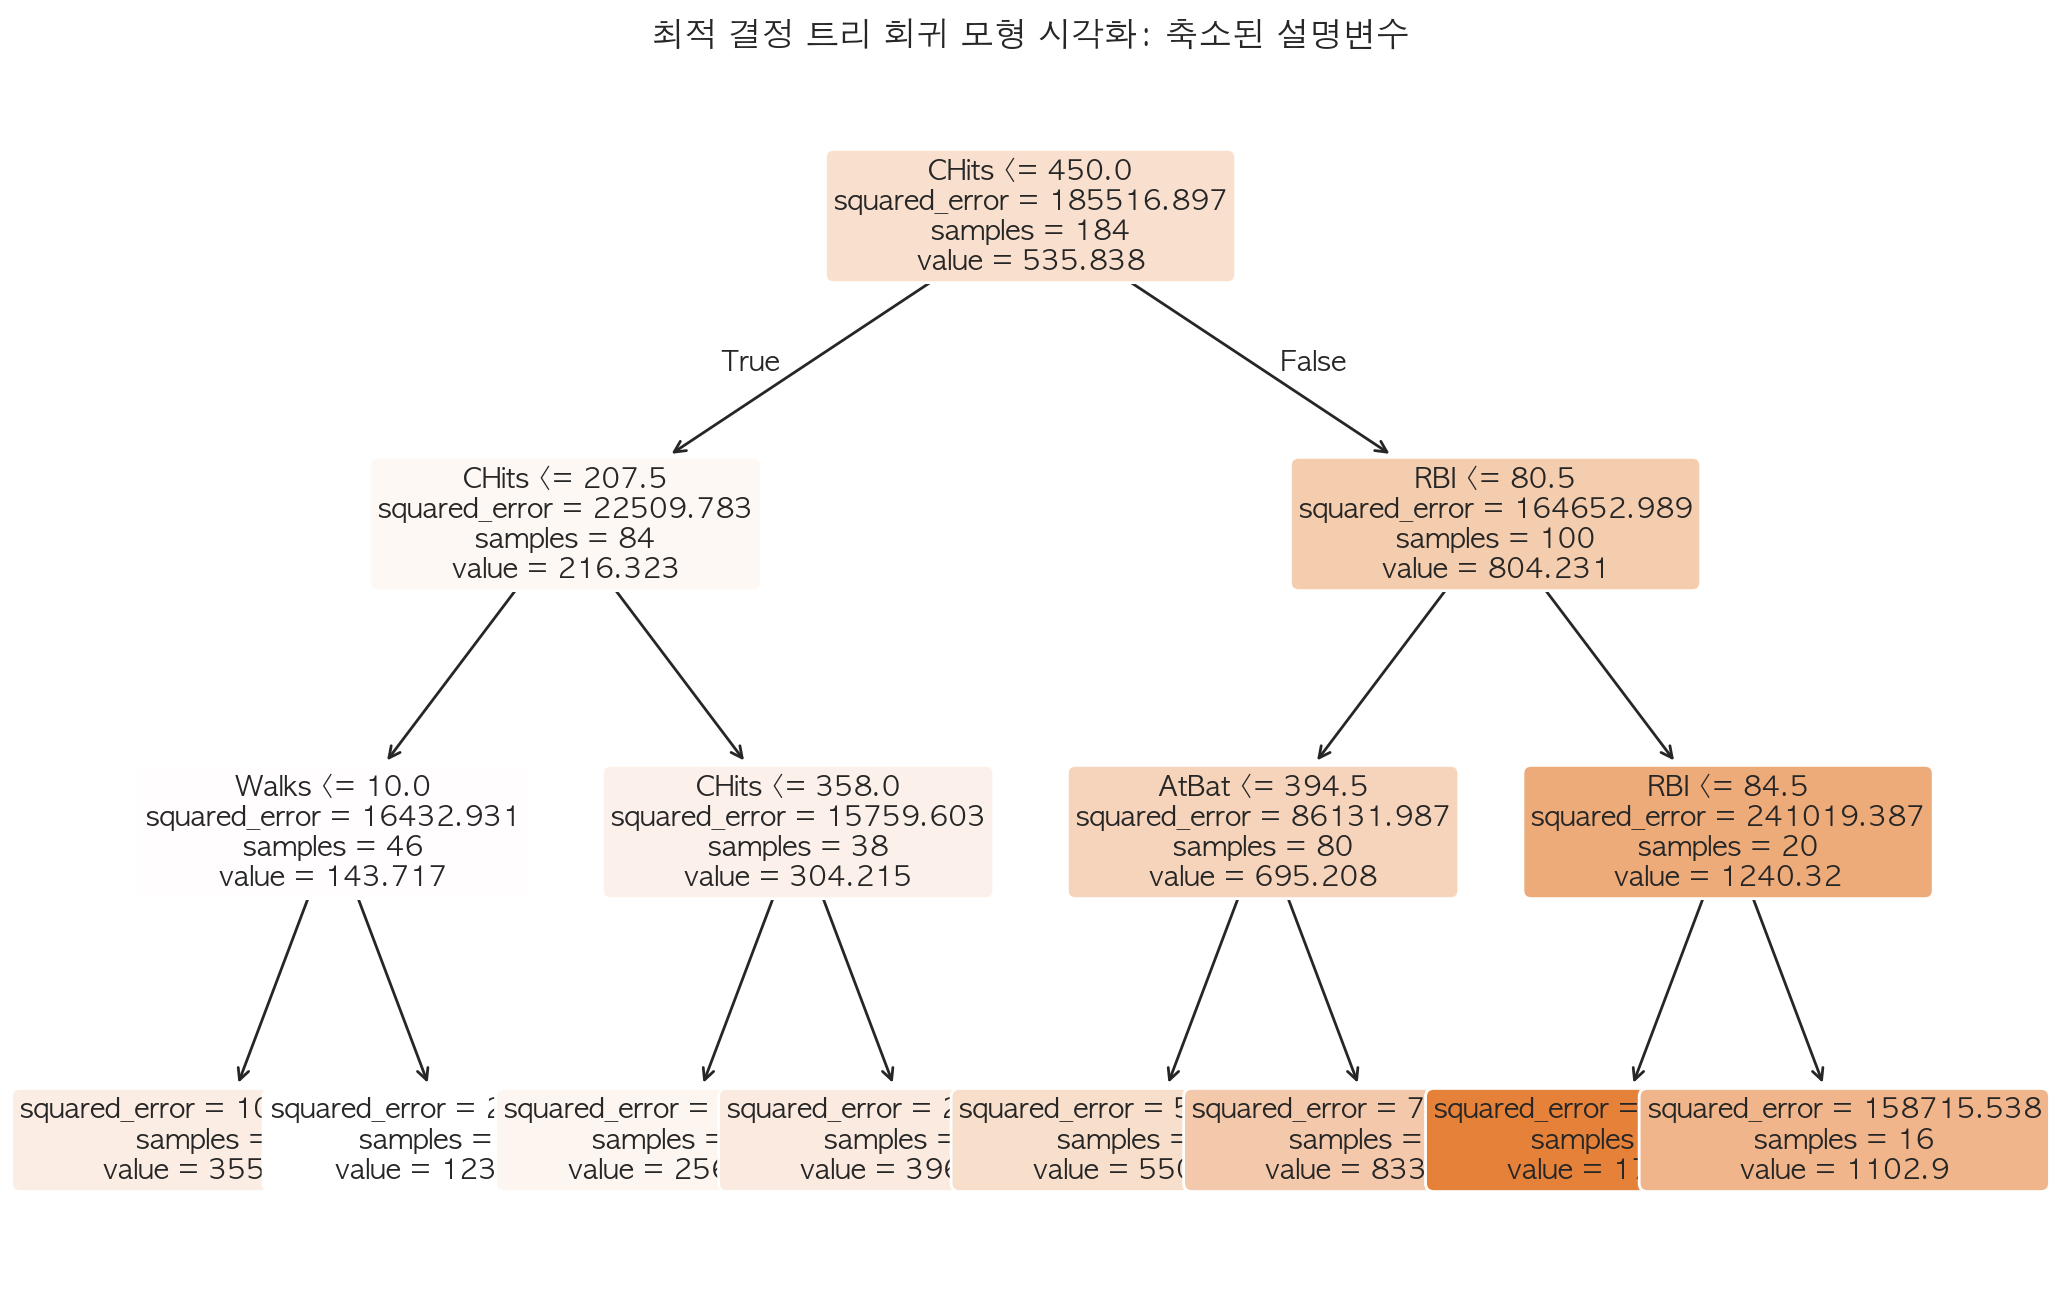

In [63]:
plt.figure(figsize=(12, 8))
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')
plt.rc('font', family='AppleGothic')
plot_tree(best_dt, 
          filled=True, 
          feature_names=list(X.columns),
          rounded=True, 
          fontsize=10)
plt.title("최적 결정 트리 회귀 모형 시각화: 축소된 설명변수")
plt.show()

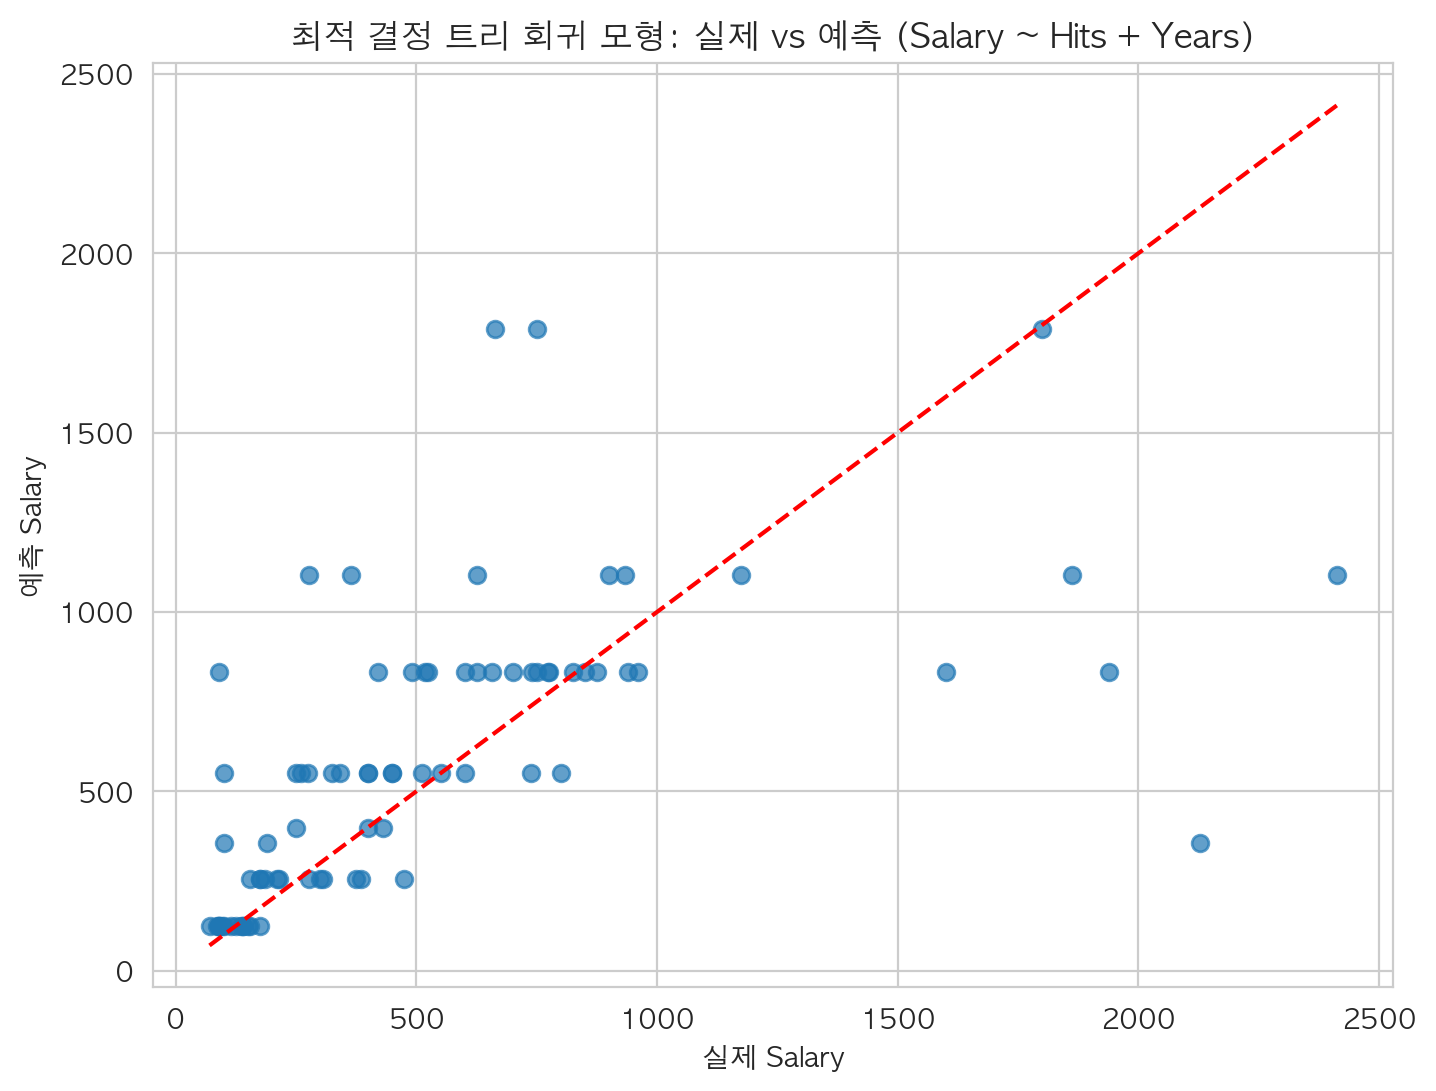

In [65]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('실제 Salary')
plt.ylabel('예측 Salary')
plt.title('최적 결정 트리 회귀 모형: 실제 vs 예측 (Salary ~ Hits + Years)')
plt.show()

In [66]:
importances = best_dt.feature_importances_

In [67]:
feature_names = list(X.columns)

In [68]:
indices = np.argsort(importances)[::-1]

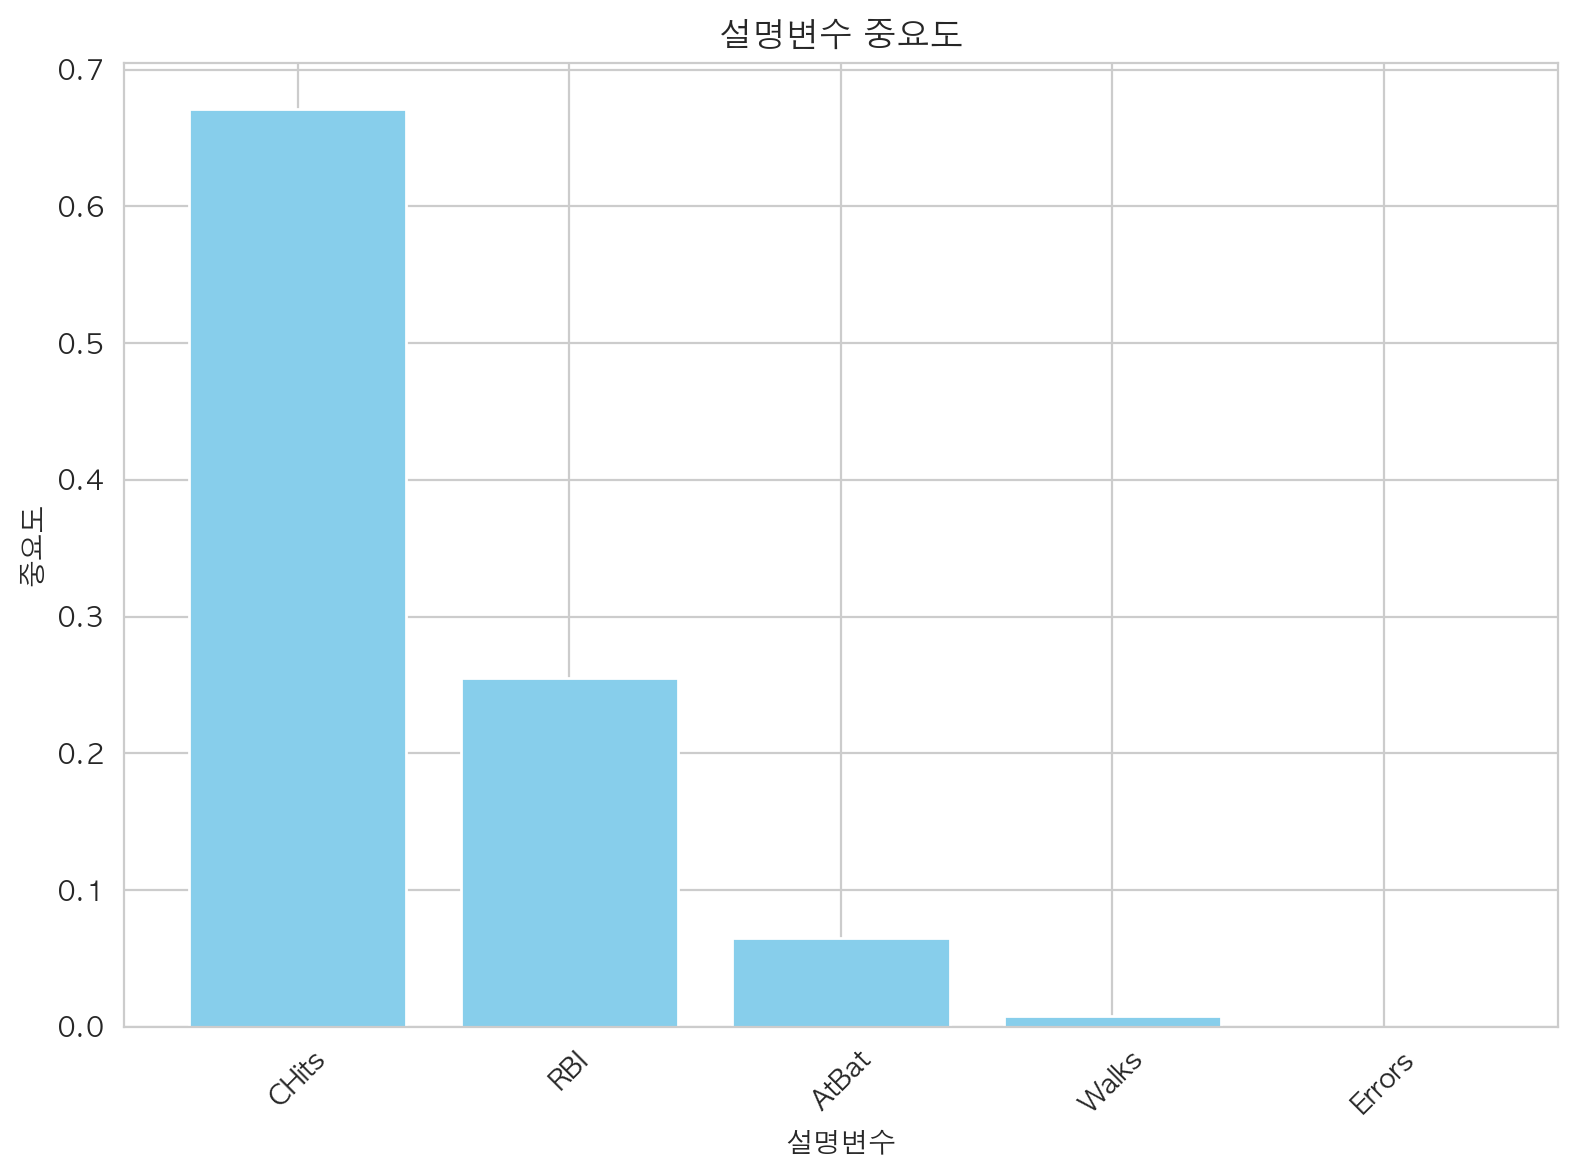

In [69]:
plt.figure(figsize=(8, 6))
plt.title("설명변수 중요도")
plt.bar(range(len(feature_names)), importances[indices], color='skyblue', align='center')
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.xlabel("설명변수")
plt.ylabel("중요도")
plt.tight_layout()
plt.show()